In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
from bicycle import *
from bicycle_control import *

In [3]:
import sys 
sys.path.append('..')
from codeprint import RawCode

# Stanley Control

### Bicycle Class : BicycleModel + Visualization

In [4]:
# 3 bicycles
bicycles = [Bicycle(L=2, dt=0.1, model_type='front') for _ in range(3)]
for bicycle in bicycles:
    bicycle.view = [-5, 20, -5, 20]


### Bicycle : set starting point

In [5]:
start1 = [0,5,2]
start2 = [1,10,-1]
start3 = [3,-4,0.5]
starts = [start1, start2, start3]
for bicycle, start in zip(bicycles, starts):
    bicycle.set_state(start,0)


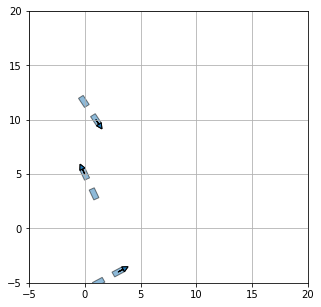

In [6]:
#visualize
fig, ax = plt.subplots(figsize=[5,5])
for bicycle in bicycles:
    bicycle.show()

### Path

In [7]:
def draw_line(line):
    ax = plt.gca()
    xx = np.arange(-20,20,0.1)
    ax.plot(xx, line(xx), 'k--')
a, b, c = -1, 2, 3
line = lambda x: -a*x/b - c/b

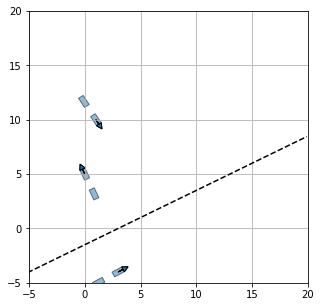

In [8]:
fig, ax = plt.subplots(figsize=[5,5])
draw_line(line)
for bicycle in bicycles:
    bicycle.show()

## Stanley Control Class

In [9]:
code = RawCode('bicycle_control.py')
code.show('Stanley')

class Stanley():
    def __init__(self, line_coeff, gain, gamma_max):
        self.line_coeff = line_coeff
        self.theta_d = np.arctan2(-line_coeff[0], line_coeff[1])
        self.gain = gain
        self.gamma_max = gamma_max

    def ctrl(self, state, v):
        convert_angle = lambda x: x if (-np.pi < x)&(x <= np.pi) \
                                    else x - np.sign(x)*np.pi*2
        
        theta = state[2]
        heading_err = convert_angle(self.theta_d - theta)
        crosstrack_err = self.get_crosstrack_error(state)
        gamma = heading_err + np.arctan2(self.gain * crosstrack_err, v)
        if abs(gamma) > self.gamma_max: gamma = np.sign(gamma)*self.gamma_max
        
        return gamma

    def get_crosstrack_error(self, state):
        a, b, c = self.line_coeff
        x, y = state[:2]
        return -(a*x+b*y+c)/np.sqrt(LA.norm([a, b]))


In [10]:
# a, b, c is line coeffs
stanley = Stanley([a, b, c], gain=0.5, gamma_max=np.pi/4)

### Simulation

In [11]:
def bicycle_simulation(bicycle, start_state, max_iter):
    # make dataframe for recording simulation
    state_names = ['x','y','theta']
    control_input_names = ['v','gamma']
    sim = pd.DataFrame(columns=state_names+control_input_names)
    
    # init
    sim.loc[0,state_names] = start_state
    curr_state = sim.loc[0,state_names]
    v = 2 # fixed velocity
    
    # loop
    for i in range(100):
        gamma = stanley.ctrl(curr_state, v)
        next_state = bicycle.model(curr_state, v, gamma)
        
        # record simulation
        idx = len(sim)
        sim.loc[idx,state_names] = next_state
        sim.loc[idx,control_input_names] = v, gamma
        
        # update state
        curr_state = next_state
    return sim

In [12]:
max_iter = 100
sims = [bicycle_simulation(bicycle, start, max_iter) 
        for bicycle, start in zip(bicycles, starts)]

### Visualization

In [13]:
def visualization(sim):
    # starting position
    start = sim.loc[0,['x','y','theta']]
    bicycle.set_state(start,0)
    bicycle.show()
    # end position
    final_state = sim.iloc[-1][['x','y','theta']].tolist()
    bicycle.set_state(final_state,0)
    bicycle.show()
    # path
    plt.scatter(sim.loc[:,'x'], sim.loc[:,'y'], s=1);

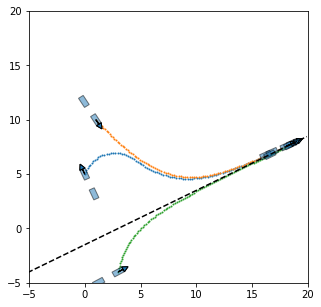

In [14]:
fig, ax = plt.subplots(figsize=[5,5])
for sim in sims:
    visualization(sim)
draw_line(line)

### draw animation

In [15]:
def init(bicycle, sim):
    start = sim.loc[0,['x','y','theta']].tolist()
    bicycle.set_state(start,0)
    bicycle.show()

In [22]:
def update(bicycle, sim, i, color='k'):
    row = sim.loc[i,:]
    state = row.loc[['x','y','theta']].to_numpy()
    gamma = row.loc['gamma']
    bicycle.set_state(state, gamma)
    bicycle.update();
    path = plt.scatter(sim.loc[:i,'x'], sim.loc[:i,'y'], s=1, color=color)
    return path

In [23]:
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS

In [24]:
from animake import AniMaker
anim = AniMaker()

image added:  100


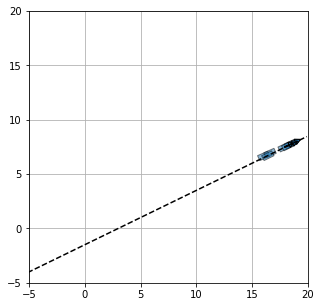

In [25]:
# init animation
fig, ax = plt.subplots(figsize=[5,5])
for bicycle, sim in zip(bicycles, sims):
    init(bicycle, sim)
draw_line(line)

# update animation and get snapshots
for i in range(100):
    paths = []
    for bicycle, sim, color in zip(bicycles, sims, colors):
        paths.append(update(bicycle, sim, i, color))
    anim.set_snapshot()
    for path in paths:
        path.remove()


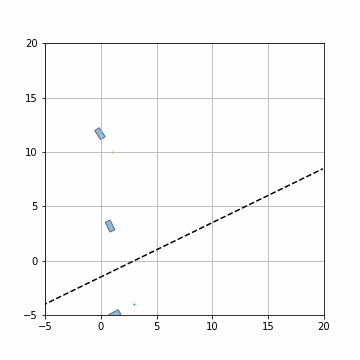

In [26]:
anim.make_gif('out_stanley.gif')
Image(filename="out_stanley.gif")